### Import libaries

In [0]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss

### Import data

In [0]:
# Read from url - Take time to run
url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
df = pd.read_csv(url, compression='bz2')

In [0]:
# Reduce rows
df = df.sample(frac=0.25)

In [6]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
5569175,2008,10,3,5,1156.0,1207,1333.0,1338,OO,6139,N698BR,157.0,151.0,130.0,-5.0,-11.0,HPN,ORD,738,16.0,11.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3901626,2008,7,24,4,NaN,720,NaN,834,US,1832,NaN,NaN,74.0,NaN,NaN,NaN,DCA,BDL,313,NaN,NaN,1,C,0,NaN,NaN,NaN,NaN,NaN
611824,2008,2,4,1,1850.0,1740,38.0,2345,WN,2006,N466WN,228.0,245.0,211.0,53.0,70.0,PHX,BWI,1999,5.0,12.0,0,NaN,0,7.0,0.0,0.0,0.0,46.0
5768613,2008,10,16,4,726.0,725,830.0,830,MQ,4397,N672MQ,64.0,65.0,43.0,0.0,1.0,ORD,RST,268,3.0,18.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
774751,2008,2,7,4,1009.0,1011,1215.0,1205,OO,3986,N429SW,126.0,114.0,81.0,10.0,-2.0,SLC,TUS,601,4.0,41.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Variable descriptions: http://stat-computing.org/dataexpo/2009/the-data.html

Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

### Data pre-processing

In [7]:
df.count()

Year                 1752432
Month                1752432
DayofMonth           1752432
DayOfWeek            1752432
DepTime              1718328
CRSDepTime           1752432
ArrTime              1714530
CRSArrTime           1752432
UniqueCarrier        1752432
FlightNum            1752432
TailNum              1731538
ActualElapsedTime    1713772
CRSElapsedTime       1752220
AirTime              1713772
ArrDelay             1713772
DepDelay             1718328
Origin               1752432
Dest                 1752432
Distance             1752432
TaxiIn               1714530
TaxiOut              1718121
Cancelled            1752432
CancellationCode       34391
Diverted             1752432
CarrierDelay          381487
WeatherDelay          381487
NASDelay              381487
SecurityDelay         381487
LateAircraftDelay     381487
dtype: int64

In [8]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             1713772
DayofMonth        1713772
DayOfWeek         1713772
CRSArrTime        1713772
UniqueCarrier     1713772
CRSElapsedTime    1713772
AirTime           1713772
ArrDelay          1713772
DepDelay          1713772
Dest              1713772
Distance          1713772
TaxiIn            1713772
TaxiOut           1713772
dtype: int64

In [0]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [0]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)
df.drop(['CRSArrTime'], axis=1, inplace=True)

In [11]:
df.dtypes

Month               int64
DayofMonth          int64
DayOfWeek           int64
UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
DepDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int64
Delay               int64
dtype: object

In [12]:
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Delay
5569175,10,3,5,OO,151.0,130.0,-5.0,-11.0,ORD,738,16.0,11.0,2,0
611824,2,4,1,WN,245.0,211.0,53.0,70.0,BWI,1999,5.0,12.0,4,1
5768613,10,16,4,MQ,65.0,43.0,0.0,1.0,RST,268,3.0,18.0,1,0
774751,2,7,4,OO,114.0,81.0,10.0,-2.0,TUS,601,4.0,41.0,2,0
6488342,12,10,3,WN,205.0,191.0,0.0,-1.0,BNA,1588,5.0,10.0,4,0


### Data analysis

In [13]:
#Check basic stats
df.describe()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
count,1.713772e+06,1.713772e+06,1.713772e+06,1.713772e+06,1.713772e+06,1.713772e+06,1.713772e+06,1.713772e+06,1.713772e+06,1.713772e+06,1.713772e+06,1.713772e+06
mean,6.390953e+00,1.573324e+01,3.925907e+00,1.290581e+02,1.040111e+02,8.202377e+00,9.956640e+00,7.286991e+02,6.858286e+00,1.643442e+01,2.242935e+00,1.317515e-01
std,3.399417e+00,8.799447e+00,1.988136e+00,6.953812e+01,6.746186e+01,3.852112e+01,3.522882e+01,5.632732e+02,4.930543e+00,1.127025e+01,1.018585e+00,3.382205e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.400000e+02,0.000000e+00,-9.000000e+01,-7.100000e+01,3.000000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,8.000000e+00,2.000000e+00,8.000000e+01,5.500000e+01,-1.000000e+01,-4.000000e+00,3.260000e+02,4.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00
50%,6.000000e+00,1.600000e+01,4.000000e+00,1.110000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,2.000000e+00,0.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,3.000000e+00,0.000000e+00
max,1.200000e+01,3.100000e+01,7.000000e+00,6.600000e+02,1.091000e+03,1.490000e+03,1.521000e+03,4.962000e+03,2.010000e+02,4.290000e+02,4.000000e+00,1.000000e+00


In [14]:
#Check correlation
df.corr()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Month,1.000000,-0.001417,-0.005053,-0.005819,-0.011958,-0.043532,-0.031543,-0.005009,0.006076,-0.017173,-0.005587,-0.036196
DayofMonth,-0.001417,1.000000,0.004363,0.001794,0.001387,0.002120,0.003737,0.001744,-0.002412,-0.000611,-0.001277,0.000662
DayOfWeek,-0.005053,0.004363,1.000000,0.015921,0.014829,0.011338,0.016366,0.017618,0.010368,-0.007466,0.003432,0.011426
CRSElapsedTime,-0.005819,0.001794,0.015921,1.000000,0.988207,0.012757,0.035147,0.983211,0.104144,0.142994,0.089790,0.031770
AirTime,-0.011958,0.001387,0.014829,0.988207,1.000000,0.035033,0.027432,0.982864,0.085175,0.108190,0.076623,0.042065
ArrDelay,-0.043532,0.002120,0.011338,0.012757,0.035033,1.000000,0.931673,0.006762,0.122736,0.321018,0.115659,0.740780
DepDelay,-0.031543,0.003737,0.016366,0.035147,0.027432,0.931673,1.000000,0.025966,0.024143,0.100680,0.141647,0.687163
Distance,-0.005009,0.001744,0.017618,0.983211,0.982864,0.006762,0.025966,1.000000,0.077002,0.091470,0.089602,0.019562
TaxiIn,0.006076,-0.002412,0.010368,0.104144,0.085175,0.122736,0.024143,0.077002,1.000000,0.039285,-0.020413,0.089471
TaxiOut,-0.017173,-0.000611,-0.007466,0.142994,0.108190,0.321018,0.100680,0.091470,0.039285,1.000000,0.056841,0.289080


In [15]:
# Groupby carrier
df.groupby(['UniqueCarrier']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
UniqueCarrier,,,,,,,,,,,,
9E,6.485728,15.730205,3.912777,100.216043,71.013162,4.011493,6.712666,450.194631,8.507109,17.994600,2.194112,0.106227
AA,6.456901,15.783197,3.956736,167.288117,141.596562,12.582145,13.179643,1054.351413,8.242988,16.851069,2.322573,0.170504
AQ,1.491746,15.466733,4.001501,75.437719,61.926963,-3.351676,-1.797899,423.591296,3.890445,8.071036,2.100050,0.018509
AS,6.379383,15.713933,3.945987,154.827409,131.632510,4.876859,6.665262,959.038846,5.775893,15.630523,2.338148,0.108752
B6,6.407221,15.796784,3.992551,180.144310,150.643718,11.070070,12.685922,1103.963710,6.227762,21.656977,2.342691,0.166428
CO,6.317695,15.735011,3.911393,186.407611,155.946135,10.869468,12.928594,1154.584075,7.928076,20.474274,2.308155,0.151086
DL,6.486266,15.703654,3.915000,156.392717,127.034312,7.798429,7.916181,926.361589,8.678991,20.561662,2.248688,0.117959
EV,6.523310,15.674954,3.934846,95.763651,70.008752,10.493164,12.161717,444.696856,7.349052,16.737293,2.103719,0.151615
F9,6.494618,15.709891,3.951352,143.208789,121.510679,6.097720,5.904441,878.860073,7.378719,14.512671,2.344309,0.094372


In [16]:
# Groupby destination airport
df.groupby(['Dest']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Dest,,,,,,,,,,,,
ABE,6.552398,15.576377,3.866785,100.418295,73.793073,8.271758,10.702487,533.602131,4.595915,19.598579,2.767318,0.151865
ABI,6.572519,16.482443,3.925191,53.219847,33.531298,8.903817,10.114504,158.000000,3.493130,14.984733,2.651908,0.140458
ABQ,6.427206,15.798127,3.929522,115.056974,93.130015,6.206111,9.326072,658.665352,5.323903,13.483095,2.275604,0.110498
ABY,5.952381,15.418367,3.979592,54.122449,27.693878,12.846939,12.659864,146.000000,3.588435,23.027211,2.479592,0.153061
ACK,7.163934,16.401639,3.950820,87.057377,46.803279,25.131148,22.180328,208.344262,5.967213,37.237705,2.254098,0.311475
ACT,5.987654,16.240741,3.948560,45.059671,23.500000,5.267490,6.849794,89.000000,4.973251,15.004115,2.129630,0.100823
ACV,6.649104,15.481560,3.949420,77.151739,57.446786,11.435195,10.730242,270.051633,4.464700,15.945205,2.497366,0.165437
ACY,2.400000,16.050000,3.650000,114.700000,87.200000,3.100000,4.850000,678.000000,3.350000,22.400000,3.200000,0.050000
ADK,6.166667,11.444444,5.333333,186.333333,171.277778,11.666667,9.166667,1192.000000,4.777778,12.777778,2.500000,0.111111


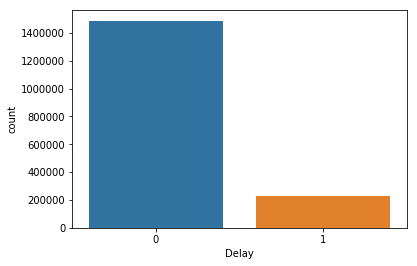

In [17]:
# Bias check
sns.countplot(x="Delay", data=df)

In [0]:
# Check Correlation
def cramers_corrected_stat(x, y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

#### Month

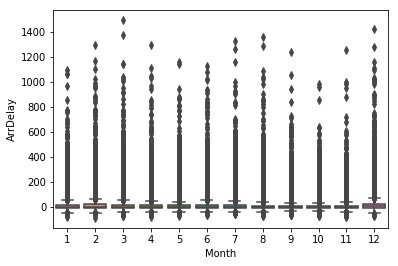

In [19]:
sns.boxplot(x='Month', y='ArrDelay', data=df) #x is feature, y is target

In [20]:
cramers_corrected_stat(df['Delay'], df['Month'])

0.118092

#### DayofMonth

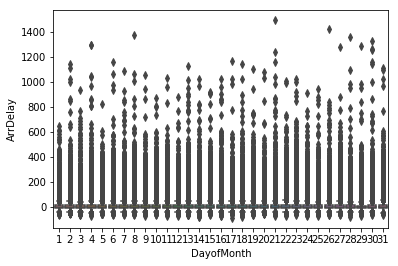

In [21]:
sns.boxplot(x='DayofMonth', y='ArrDelay', data=df) #x is feature, y is target

In [22]:
cramers_corrected_stat(df['Delay'], df['DayofMonth'])

0.035996

#### Weekend

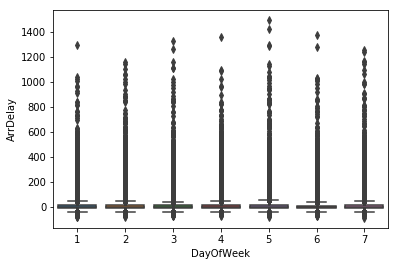

In [23]:
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df) #x is feature, y is target

In [24]:
cramers_corrected_stat(df['Delay'], df['DayOfWeek'])

0.03703

#### Parts of the Day

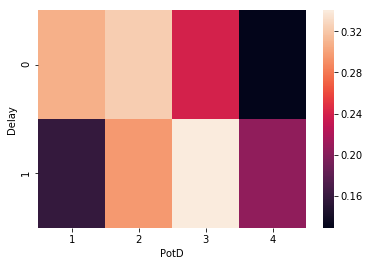

In [25]:
sns.heatmap(pd.crosstab(df['Delay'], df['PotD'], normalize='index'))

In [26]:
cramers_corrected_stat(df['Delay'], df['PotD'])

0.136497

### Encoding

In [0]:
# Apply One-hot encoding to Dest column

df = pd.concat([df, pd.get_dummies(df['Dest'], prefix='Dest',dummy_na=True)],axis=1).drop(['Dest'],axis=1)

In [0]:
# Apply One-hot encoding to UniqueCarrier column

df = pd.concat([df, pd.get_dummies(df['UniqueCarrier'], prefix='UniqueCarrier',dummy_na=True)],axis=1).drop(['UniqueCarrier'],axis=1)

In [29]:
df.head()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ABY,Dest_ACK,Dest_ACT,Dest_ACV,Dest_ACY,Dest_ADK,Dest_ADQ,Dest_AEX,Dest_AGS,Dest_AKN,Dest_ALB,Dest_ALO,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BET,Dest_BFL,Dest_BGM,...,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUP,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,Dest_nan,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,UniqueCarrier_nan
5569175,10,3,5,151.0,130.0,-5.0,-11.0,738,16.0,11.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
611824,2,4,1,245.0,211.0,53.0,70.0,1999,5.0,12.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5768613,10,16,4,65.0,43.0,0.0,1.0,268,3.0,18.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
774751,2,7,4,114.0,81.0,10.0,-2.0,601,4.0,41.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6488342,12,10,3,205.0,191.0,0.0,-1.0,1588,5.0,10.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Model evaluation

In [0]:
#features = df.drop(['Delay'], axis=1)
# Why?
# Airline:
# Dest Airport + CRSArrTime: 
# Departure features:


X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [31]:
X_train.head()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ABY,Dest_ACK,Dest_ACT,Dest_ACV,Dest_ACY,Dest_ADK,Dest_ADQ,Dest_AEX,Dest_AGS,Dest_AKN,Dest_ALB,Dest_ALO,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BET,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,...,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUP,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,Dest_nan,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,UniqueCarrier_nan
3395215,6,14,6,163.0,145.0,28.0,922,8.0,9.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5568272,10,1,3,140.0,128.0,-8.0,834,9.0,8.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6581959,12,3,3,83.0,58.0,-5.0,355,10.0,13.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1863834,4,25,5,135.0,109.0,1.0,787,6.0,9.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4744804,8,3,7,150.0,122.0,-1.0,888,8.0,15.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [31]:
# Metrics
# https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b
# Confusion Matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

[[141025  97024]
 [  4312  31825]]
              precision    recall  f1-score   support

           0       0.97      0.59      0.74    238049
           1       0.25      0.88      0.39     36137

    accuracy                           0.63    274186
   macro avg       0.61      0.74      0.56    274186
weighted avg       0.87      0.63      0.69    274186



#### Logistic Regression using GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = {'C' : np.logspace(1, 5, 10), 
        'class_weight' : ['balanced'], 
        'n_jobs':  [2]}
model = LogisticRegression()
model_cv = GridSearchCV(model, grid, cv=5)
model_cv.fit(X_data, y_data)

print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("accuracy :",model_cv.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [0]:


model = LogisticRegression( ,n_jobs = 2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### Gradient Boosting

#### Random Forest

# TODO

1. Edit threshhold / class weight
2. PCA: Dimension reducing
3. RFE: Features selection
4. GridsearchCV for tuning
- Tuning with 3 values
- Goal: Precison ~ Recall
5. Compare performances among models